In [1]:
import numpy as np
import scipy
from lib.aux import PCAVector
import os
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Example 2: One-dimensional parameter space

## Definitions

### Auxiliary functions

In [86]:
def doAnalysis(tagList):
    # summarized spectral analysis of all experiments given by tagList

    # list of time parameters, eigenvalues of psi deformations, eigenvalues of transport map deformations
    TList=[]
    eigvalListY=[]
    eigvalList=[]
    
    for tag in tagList:
        if os.path.isfile("data/"+tag+"_tan.npz"):
            
            # load problem specifications    
            data=np.load("data/"+tag+".npz")
            X=data["X"]
            mu=data["dens"]
            YList=data["YList"]
            T=float(data["t"])

            # load precomputed optimal transport maps
            dataTan=np.load("data/"+tag+"_tan.npz")
            vecList=dataTan["vec"]

            nSamp,nPts,dim=YList.shape
            
            eigval,eigvec=PCAVector(vecList/T, mu)
            order=np.argsort(-eigval)
            eigvalList.append(eigval[order])

            eigvalY,eigvecY=PCAVector((YList-X)/T, mu)
            orderY=np.argsort(-eigvalY)
            eigvalListY.append(eigvalY[orderY])
            
            TList.append(T)
    
    TList=np.array(TList)
    eigvalList=np.array(eigvalList)
    eigvalListY=np.array(eigvalListY)
    
    return TList,eigvalList,eigvalListY

def getTangentNorm(Z,mu):
    return np.linalg.norm(Z,axis=1)@mu

def plotEigvals(ax,TList,eigvalList,lines=False,**kwargs):
    nT,keep=eigvalList.shape
    if lines:
        for i in range(keep):
            ax.plot(TList,eigvalList[:,i],**kwargs)
    else:
        for i in range(keep):
            ax.scatter(TList,eigvalList[:,i],**kwargs)


In [9]:
def addLines(ax,X,Y,**kwargs):
    """Add line collection from points in X to points in Y to axis object. X,Y are assumed to have shape [nPoints,dim]."""
    linecoords=np.stack([X,Y],axis=1)
    lineCollection=matplotlib.collections.LineCollection(linecoords,**kwargs)
    ax.add_collection(lineCollection)


# visualize a covariance matrix as ellipse, helps to visualize parametric family of vector fields
def getEllipse(mean,cov,**kwargs):
    eigval,eigvec=np.linalg.eigh(cov)
    eigvec=eigvec.T
    phi=np.arctan2(eigvec[0,1],eigvec[0,0])
    phi=phi/np.pi*180
    #print(phi)
    e=matplotlib.patches.Ellipse(mean,2*eigval[0]**0.5,2*eigval[1]**0.5,angle=phi,**kwargs)
    return e

# for a time parameter t, and on a grid X, draw the vector field v
# and visualize its parametrization with ellipses that show the Gaussian bumps
def drawStuff(ax,X,t):
    zList,aList,covList=getLists(t)
    precList=np.array([np.linalg.inv(cov) for cov in covList])
    
    DPhi=getDPhi(X,zList,aList,precList)
    
    [l.remove() for l in ax.patches]
    [l.remove() for l in ax.collections]
    
    ax.scatter(X[:,0],X[:,1],s=10,zorder=2,c="C0")
    addLines(ax,X,X+DPhi,zorder=-1,lw=1,color="k")
    #linecoords=np.stack([X,X+DPhi],axis=1)
    #lineCollection=matplotlib.collections.LineCollection(linecoords,zorder=-1,lw=1,color="k")
    #ax.add_collection(lineCollection)
    for z,a,prec in zip(zList,aList,precList):
        ax.add_patch(getEllipse(z,np.linalg.inv(prec),fill=False,color="r",linewidth=2))

### Vector field and diffeomorphisms

In [10]:
# general functions for vector fields
def getPhi(x,zList,aList,precList):
    """create a quadratic potential with some gaussian bumps
    z: origins of bumps
    a: prefactors of bumps
    prec: precision matrices of bumps"""
    pot=0.5*np.einsum(x,[0,1],x,[0,1],[0])
    for z,a,prec in zip(zList,aList,precList):
        pot+=a*np.exp(-0.5*np.einsum(x-z,[0,2],prec,[2,3],x-z,[0,3],[0]))
    return pot


def getDPhi(x,zList,aList,precList,addId=False):
    """gradient of the above function wrt x.
    addId: whether to add the identity or whether to skip it"""
    if addId:
        grad=x.copy()
    else:
        grad=np.zeros_like(x)
    for z,a,prec in zip(zList,aList,precList):
        grad-=a*np.exp(-0.5*np.einsum(x-z,[0,2],prec,[2,3],x-z,[0,3],[0])).reshape((-1,1))*(x-z)@prec
    return grad

def getHPhi(x,zList,aList,precList):
    """Hessian of the above function wrt x."""
    n,dim=x.shape
    hess=np.zeros((n,dim,dim))
    for i in range(dim):
        hess[:,i,i]=1.
    
    for z,a,prec in zip(zList,aList,precList):
        hess+=a*np.exp(-0.5*np.einsum(x-z,[0,2],prec,[2,3],x-z,[0,3],[0])).reshape((-1,1,1))*(\
            -prec.reshape((1,dim,dim))
            +np.einsum(prec,[0,1],(x-z),[2,1],(x-z),[2,3],prec,[3,4],[2,0,4]))
    return hess

In [11]:
# integration of flow
# this already uses the function getLists defined further down
# in which a specific family of vector fields is parametrized in time

# parametric vector field, evaluated on point cloud x, which is assumed to be flattened
def fun(t,x,sign=1):
    zList,aList,covList=getLists(t)
    precList=np.array([np.linalg.inv(cov) for cov in covList])
    if x.ndim==1:
        DPhi=getDPhi(x.reshape((-1,2)),zList,aList,precList)
        return sign*4*DPhi.ravel()
    else:
        DPhi=getDPhi(x,zList,aList,precList)
        return sign*4*DPhi

# compute psi by integrating flow wrt t (which is the parameter theta)
def solveflow(x0,t,returnFull=False,numODE=100):
    if np.abs(t)<1E-5:
        return x0
    if t>0:
        funEff=lambda t,x : fun(t,x,1)
    if t<0:
        funEff=lambda t,x : fun(-t,x,-1)
    y0=x0.ravel()
    t_span=[0,np.abs(t)]
    t_eval=np.linspace(*t_span,num=numODE)
    res=scipy.integrate.solve_ivp(funEff, t_span, y0, method='RK45', t_eval=t_eval)
    if returnFull:
        return res["y"].reshape((-1,2,numODE)).transpose((2,0,1))
    else:
        return res["y"][:,-1].reshape((-1,2))

### A simple parametric vector field and template

In [12]:
def getR(phi):
    return np.array([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]])

def getLists(t):
    delta=0.6
    zList=2*np.array([[np.cos(t-delta),np.sin(t-delta)],[-np.cos(t-delta),-np.sin(t-delta)]])
    aList=np.array([-1.,-1])
    covList=np.zeros((2,2,2),dtype=np.double)
    covList[0]=2.*np.array([[1.,0],[0,1.]])
    covList[1]=2.*np.array([[1.,0],[0,1.]])
    return zList,aList,covList


In [13]:
# create template
dim=2
def getData(scale):
    """Return point cloud X and weights dens, given a scale parameter (which should be integer, usually 1,2,4,...)"""
    x = np.linspace(-1,1,num=50*scale)
    y = np.linspace(-0.5,0.5,num=25*scale)
    X = np.stack(np.meshgrid(x, y),axis=2).reshape((-1,dim))
    
    dens=np.ones(X.shape[0],dtype=np.double)
    dens/=np.sum(dens)

    return X,dens

## Plotting and designing

### Static plot

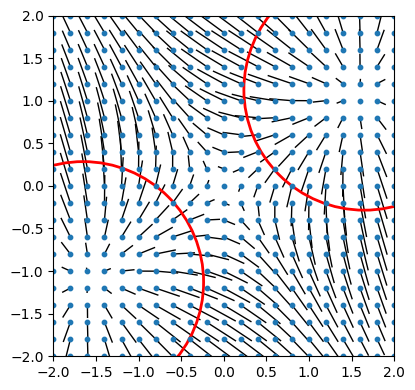

In [16]:
# basic plot of vector field on a simple grid
%matplotlib inline

xPlt = np.linspace(-2,2,num=21)
XPlt = np.stack(np.meshgrid(xPlt, xPlt),axis=2).reshape((-1,dim))


fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(aspect=1.)
drawStuff(ax,XPlt,1.2)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.tight_layout()
plt.show()

### Dynamic plot

In [19]:
# show vector field at various times

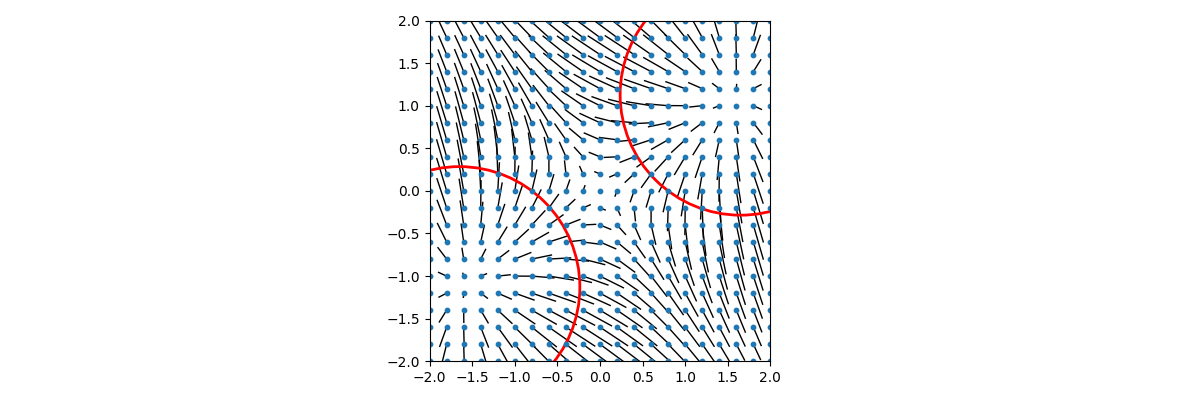

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, min=-1.0), Output()), _dom_classes=('wi…

In [17]:
%matplotlib widget
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(aspect=1.)
drawStuff(ax,XPlt,1.2)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.tight_layout()
plt.show()

def update(t):
    drawStuff(ax,XPlt,t)
    fig.canvas.draw_idle()
    
widgets.interact(update, t = (-1.,1.));


In [20]:
plt.close()

### Dynamic plot of deformed template

In [22]:
# create a small template
scale=1
X,dens=getData(scale)
print(X.shape)

(1250, 2)


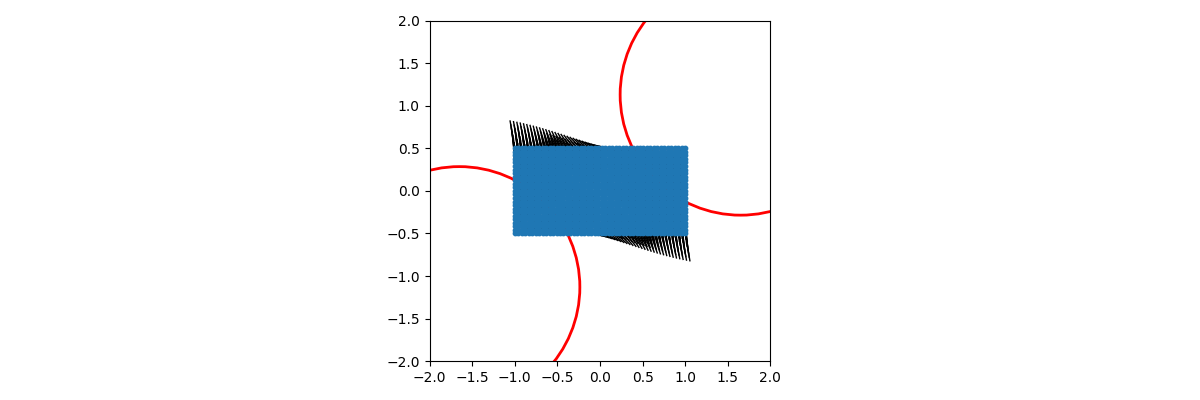

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, min=-1.0), Output()), _dom_classes=('wi…

In [23]:
%matplotlib widget
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(aspect=1.)
drawStuff(ax,X,1.2)
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.tight_layout()
plt.show()

def update(t):
    Y=solveflow(X,t)

    zList,aList,covList=getLists(t)
    precList=np.array([np.linalg.inv(cov) for cov in covList])
    
    DPhi=getDPhi(Y,zList,aList,precList)
    
    [l.remove() for l in ax.patches]
    [l.remove() for l in ax.collections]
    
    ax.scatter(Y[:,0],Y[:,1],s=10,zorder=2,c="C0")
    addLines(ax,Y,Y+DPhi,zorder=-1,lw=1,color="k")
    for z,a,prec in zip(zList,aList,precList):
        ax.add_patch(getEllipse(z,np.linalg.inv(prec),fill=False,color="r",linewidth=2))


    fig.canvas.draw_idle()
    #print("x")
    
widgets.interact(update, t = (-1.,1.));




In [10]:
plt.close()

### Static plot of several deformed templates

In [53]:
t=1.
scale=1
X,dens=getData(scale)
numODE=100
tList=np.linspace(0,t,num=numODE)
sol=solveflow(X,t,returnFull=True,numODE=numODE)

In [54]:
vel=np.array([fun(s,Y) for s,Y in zip(tList,sol)])

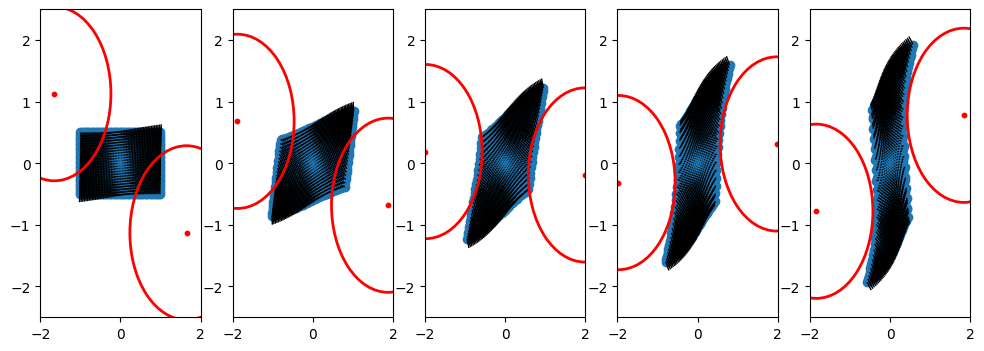

In [58]:
%matplotlib inline
fig=plt.figure(figsize=(12,4))
iList=[0,25,50,75,99]
for j,i in enumerate(iList):
    ax=fig.add_subplot(1,len(iList),j+1)
    ax.scatter(sol[i,:,0],sol[i,:,1],zorder=-1)
    addLines(ax,sol[i],sol[i]+0.1*vel[i],zorder=-1,lw=1,color="k")

    t=tList[i]
    zList,aList,covList=getLists(t)
    precList=np.array([np.linalg.inv(cov) for cov in covList])
    
    ax.scatter(zList[:,0],zList[:,1],s=10,zorder=2,c="r")
    for z,a,prec in zip(zList,aList,precList):
        ax.add_patch(getEllipse(z,np.linalg.inv(prec),fill=False,color="r",linewidth=2))

    
    ax.set_xlim([-2,2])
    ax.set_ylim([-2.5,2.5])
plt.show()

# Tangent space analysis

## Generate sample measures

In [102]:
# template and resolution
# scale should be one of [1,2,4]
scale=1
X,dens=getData(scale)
print(X.shape)

(1250, 2)


In [103]:
# time scaling

# geometric scaling factor: 10 steps per order of magnitude
q=10**(-0.1)
TList=q**np.arange(8)
idList=list(range(len(TList)))
print(TList)

[1.         0.79432823 0.63095734 0.50118723 0.39810717 0.31622777
 0.25118864 0.19952623]


In [104]:
# tag list for storage and retrieval of experiment data
tagList=[f"example2/scale_{scale:}/{i:02}" for i in range(len(TList))]
print(tagList)

['example2/scale_1/00', 'example2/scale_1/01', 'example2/scale_1/02', 'example2/scale_1/03', 'example2/scale_1/04', 'example2/scale_1/05', 'example2/scale_1/06', 'example2/scale_1/07']


In [105]:
# parameters for solver script
# will be added to config file for documentation purposes
if scale==1:
    paramsSolver={"param_hierarchyDepth":6,"param_eps":5e-4,"param_afterSteps":7}
elif scale==2:
    paramsSolver={"param_hierarchyDepth":7,"param_eps":1.2e-4,"param_afterSteps":7}
elif scale==4:
    paramsSolver={"param_hierarchyDepth":8,"param_eps":3e-5,"param_afterSteps":7}
else:
    raise ValueError("no solver params specified for given scale.")

In [106]:
for tag,T in zip(tagList,TList):
    # parameters that should be used as tangent vectors
    thetaList=T*np.linspace(-1,1,num=10)
    # deformed template positions
    YList=[solveflow(X,theta) for theta in thetaList]
    # deformed densities (just copies)
    densList=np.repeat(dens.reshape((1,-1)),len(YList),axis=0)
    data={"t":T,"thetaList":thetaList,"YList":YList,"X":X,"theta0":0,"dens":dens,"densList":densList}
    # next line commented to avoid accidental overwriting
    #np.savez("data/"+tag+".npz",**data,**paramsSolver)

## Solve transport problems

In [107]:
# now need to run:
# path/to/python3 ./solve-experiments.py tag
# for all tag in tag list, then can continue with evaluation of results
# for simplicity, the repository contains the config and results files for scale=1

## Spectral analysis

In [109]:
scale=1
tagList=[f"example2/scale_{scale:}/{i:02}" for i in range(len(TList))]
specTList,eigvalList,eigvalListY=doAnalysis(tagList)

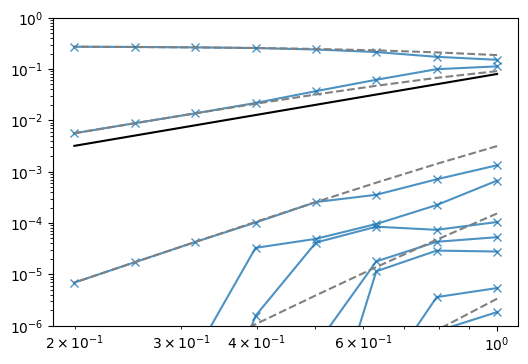

In [114]:
%matplotlib inline
ylim=[1E-6,1E0]
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(1,1,1)
plotEigvals(ax,specTList,eigvalList,lines=True,marker="x",color="C0",alpha=0.8)
plotEigvals(ax,specTList,eigvalListY,lines=True,marker="",color="#808080",ls="dashed")
plt.plot(specTList,0.08*specTList**2,c="k")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(ylim)


plt.show()

## Convergence analysis of infinitesimal deformation

In [100]:
scale=1
tagList=[f"example2/scale_{scale:}/{i:02}" for i in range(8)]

# load initial positions
tag=tagList[0]
data=np.load("data/"+tag+".npz")
X=data["X"]
# obtain ground truth infinitesimal displacement field
v=fun(0,X)

deviationList=[]
thetaList=[]

for tag in tagList:
    if os.path.isfile("data/"+tag+"_tan.npz"):
        # compare with computed displacement (renormalized to velocity)
        data=np.load("data/"+tag+".npz")
        dataTan=np.load("data/"+tag+"_tan.npz")
        thetaListSub=data["thetaList"]
        vecList=dataTan["vec"]
        mu=data["dens"]
    
        wList=[vec/theta for vec,theta in zip(vecList,thetaListSub)]
    
        thetaList.extend(thetaListSub)
        deviationList.extend(np.array([getTangentNorm(w-v,mu) for w in wList]))

thetaList=np.array(thetaList)
absThetaList=np.abs(thetaList)
deviationList=np.array(deviationList)
# compare in tangent norm


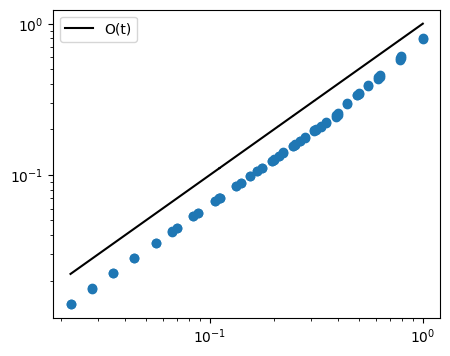

In [101]:
fig=plt.figure(figsize=(5,4))
ax=fig.add_subplot(1,1,1)

ax.scatter(absThetaList,deviationList)
ax.plot(np.sort(absThetaList),np.sort(absThetaList),label="O(t)",c="k")
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend()
plt.show()

## Metrics along the path

In [68]:
tag="example2/scale_1/00"

# load problem data
data=np.load("data/"+tag+".npz")
dataTan=np.load("data/"+tag+"_tan.npz")
X=data["X"]
mu=data["dens"]
YList=data["YList"]
vecList=dataTan["vec"]
tList=data["thetaList"]
distListPsi=[]
distListW=[]
distListLambda=[]
thetaList=[]

In [69]:
# integrate flow and compute length of path
t=1.
numODE=101
deltaT=t/(numODE-1)
sol=solveflow(X,t,returnFull=True,numODE=numODE)

vel=sol[1:,:,:]-sol[:-1,:,:]
velNorm=np.linalg.norm(vel,axis=2)
lenSegments=np.sum(velNorm*mu,axis=1)
pathTimes=(np.arange(numODE-1)+1)*deltaT
pathDist=np.cumsum(lenSegments)

In [70]:
# compute Y-deformation lengths
YDist=np.linalg.norm(YList-X,axis=2)@mu
# transport cost
WDist=np.linalg.norm(vecList,axis=2)@mu

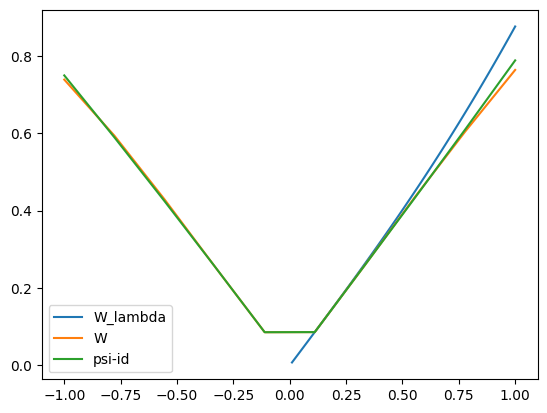

In [73]:
%matplotlib inline
plt.plot(pathTimes,pathDist,label="W_lambda")
plt.plot(tList,WDist,label="W")
plt.plot(tList,YDist,label="psi-id")
plt.legend()
plt.show()